# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
entropy = - (0.8 * np.log(0.8) + 0.2 * np.log(0.2))
print(round(entropy,2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
Q = (0.8 * (1 - 0.8) + 0.2 * (1 - 0.2)) - (8/10) * (0.8 * (1 - 0.8)) - (2/10) *  (0.2 * (1 - 0.2))
print(round(Q, 2))

0.16


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [9]:
target = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

print("Предсказание модели:", sum(target)/len(target))

Предсказание модели: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [4]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [2]:
def gini_impurity(y: np.ndarray) -> float:
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities ** 2)

In [14]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if feature_type == 'real':

        sorted_index = np.argsort(feature_vector)
        sorted_feature = feature_vector[sorted_index]
        sorted_target = target_vector[sorted_index]
        
        thresholds = (sorted_feature[:-1] + sorted_feature[1:]) / 2
        if len(thresholds) == 0:
            return np.array([]), np.array([]), None, None
        
        if task == "classification":
            total_gini = []
            
            for threshold in thresholds:
                left_mask = sorted_feature <= threshold
                right_mask = ~left_mask
                
                left_target = sorted_target[left_mask]
                right_target = sorted_target[right_mask]
                
                left_gini = gini_impurity(left_target)
                right_gini = gini_impurity(right_target)
                
                total_gini.append((len(left_target) * left_gini + len(right_target) * right_gini) / len(sorted_feature))
            
            ginis = np.array(total_gini)
            best_idx = np.argmin(ginis)
            return thresholds, ginis, thresholds[best_idx], ginis[best_idx]
        
        elif task == "regression":
            left_sums = np.cumsum(sorted_target)[:-1]
            right_sums = np.cumsum(sorted_target[::-1])[:-1][::-1]
            
            left_sq_sums = np.cumsum(sorted_target ** 2)[:-1]
            right_sq_sums = np.cumsum(sorted_target[::-1] ** 2)[:-1][::-1]
            
            left_counts = np.arange(1, len(sorted_target))
            right_counts = len(sorted_target) - left_counts
            
            left_means = left_sums / left_counts
            right_means = right_sums / right_counts
            
            left_vars = left_sq_sums / left_counts - left_means ** 2
            right_vars = right_sq_sums / right_counts - right_means ** 2
            
            total_variances = (left_vars * left_counts + right_vars * right_counts) / len(sorted_target)
            
            best_idx = np.argmin(total_variances)
            return thresholds, total_variances, thresholds[best_idx], total_variances[best_idx]

    elif feature_type == 'categorical':
        unique_values = np.unique(feature_vector)
        best_gini = float('inf')
        best_variance = float('inf')
        best_split = None

        if task == "classification":
            total_gini = []
            
            for value in unique_values:
                left_mask = feature_vector == value
                right_mask = ~left_mask
                
                left_target = target_vector[left_mask]
                right_target = target_vector[right_mask]
                
                left_gini = gini_impurity(left_target)
                right_gini = gini_impurity(right_target)
                
                total_gini.append((len(left_target) * left_gini + len(right_target) * right_gini) / len(feature_vector))
            
            ginis = np.array(total_gini)
            best_idx = np.argmin(ginis)
            best_split = unique_values[best_idx]
            return unique_values, ginis, best_split, ginis[best_idx]

        elif task == "regression":
            total_variances = []
            
            for value in unique_values:
                left_mask = feature_vector == value
                right_mask = ~left_mask
                
                left_target = target_vector[left_mask]
                right_target = target_vector[right_mask]
                
                left_variance = np.var(left_target)
                right_variance = np.var(right_target)
                
                total_variances.append((len(left_target) * left_variance + len(right_target) * right_variance) / len(feature_vector))
            
            variances = np.array(total_variances)
            best_idx = np.argmin(variances)
            best_split = unique_values[best_idx]
            return unique_values, variances, best_split, variances[best_idx]

    return np.array([]), np.array([]), None, None

Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [13]:
thresholds, criterion_values, threshold_best, criterion_best = find_best_split(
    X['MedInc'].values.reshape(-1, 1), 
    y, 
    task='regression' )

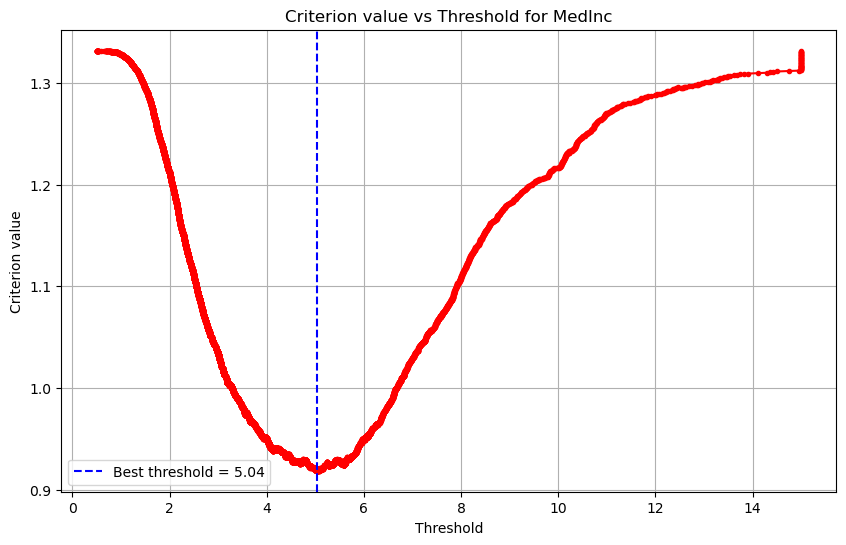

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, criterion_values, marker='.', linestyle='-', color='r')
plt.axvline(x=threshold_best, color='b', linestyle='--', label=f'Best threshold = {threshold_best:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Criterion value')
plt.title('Criterion value vs Threshold for MedInc')
plt.legend()
plt.grid(True)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [22]:
best_feature = None
best_threshold = None
best_criterion_value = float('inf')

for feature in X.columns:
    feature_vector = X[feature].values
    target_vector = y
    
    thresholds, criterion_values, threshold_best, criterion_best = find_best_split(
        feature_vector,
        target_vector,
        task='regression'  
    )
    
    if criterion_best < best_criterion_value:
        best_criterion_value = criterion_best
        best_feature = feature
        best_threshold = threshold_best

print(f'Лучший предикат: Признак = {best_feature}, Порог = {best_threshold}, Значение критерия = {best_criterion_value}')

Лучший предикат: Признак = MedInc, Порог = 5.03515, Значение критерия = 0.9187989138801249


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [26]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification",
        missing_values: Union[float, str, None] = None
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is an unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # Типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # Гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная для хранения важности признаков
        self._feature_importances = {}
        
        # Пропущенные значения
        self._missing_values = missing_values
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # Критерий останова
        if np.all(sub_y == sub_y[0]) or len(sub_X) <= self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            # Подготовка признака для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
                if self._missing_values is not None:
                    feature_vector = np.where(np.isnan(feature_vector), self._missing_values, feature_vector)
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]
                if self._missing_values is not None:
                    feature_vector = np.where(feature_vector == "", self._missing_values, feature_vector)
                

            # Поиск оптимального порога
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                split = (feature_vector <= threshold)

                # Увеличение значения важности признака
                if feature in self._feature_importances:
                    self._feature_importances[feature] += 1
                else:
                    self._feature_importances[feature] = 1


        # Запись полученных сплитов в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        else:
            feature_index = node["feature_split"]
            if self._feature_types[feature_index] == "real":
                if x[feature_index] <= node["threshold"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
            elif self._feature_types[feature_index] == "categorical":
                if x[feature_index] == node["category_split"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
            else:
                raise ValueError("Unknown feature type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)
    
    def _compute_feature_importances(self) -> None:
        total_splits = sum(self._feature_importances.values())
        for feature, importance in self._feature_importances.items():
            self._feature_importances[feature] = importance / total_splits if total_splits else 0


**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [30]:
data_students = pd.read_csv('students.csv')
data_students.drop(columns = ["Unnamed: 0"], inplace = True)
X = data_students.iloc[:, :-1]  
y = data_students.iloc[:, -1] 

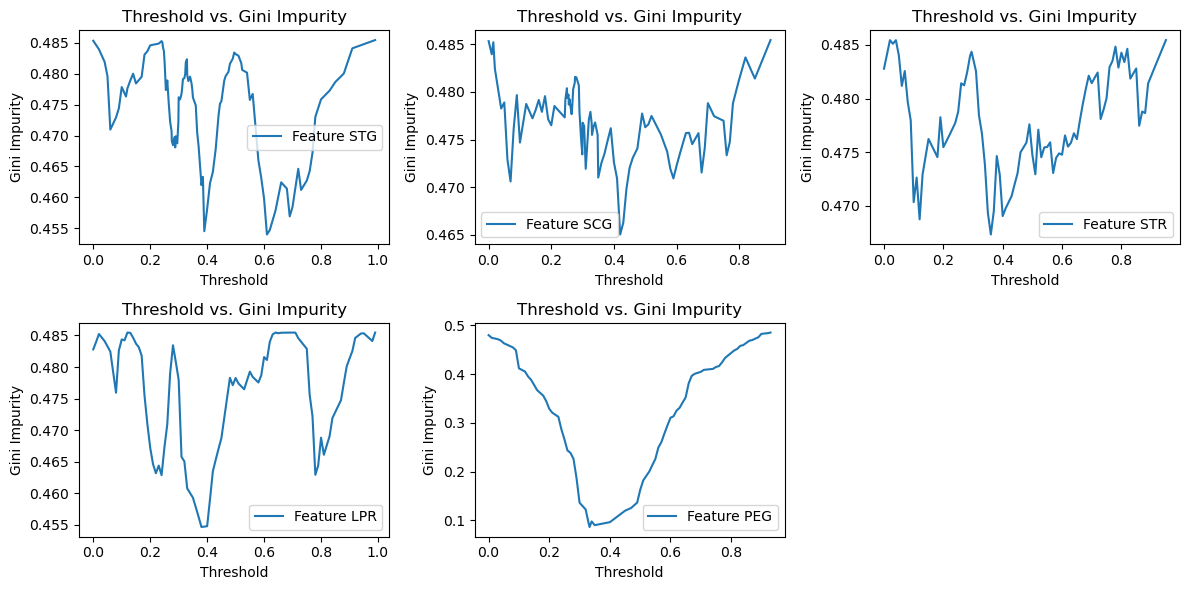

In [32]:
def plot_threshold_gini(feature, target):
    thresholds = np.unique(feature)
    ginis = []
    for threshold in thresholds:
        left_mask = feature <= threshold
        right_mask = ~left_mask
        left_gini = gini_impurity(target[left_mask])
        right_gini = gini_impurity(target[right_mask])
        weighted_gini = (left_gini * sum(left_mask) + right_gini * sum(right_mask)) / len(target)
        ginis.append(weighted_gini)
    plt.plot(thresholds, ginis, label='Feature {}'.format(feature.name))
    plt.xlabel('Threshold')
    plt.ylabel('Gini Impurity')
    plt.title('Threshold vs. Gini Impurity')
    plt.legend()
plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns):
    plt.subplot(2, 3, i+1)
    plot_threshold_gini(X[col], y)
plt.tight_layout()
plt.show()

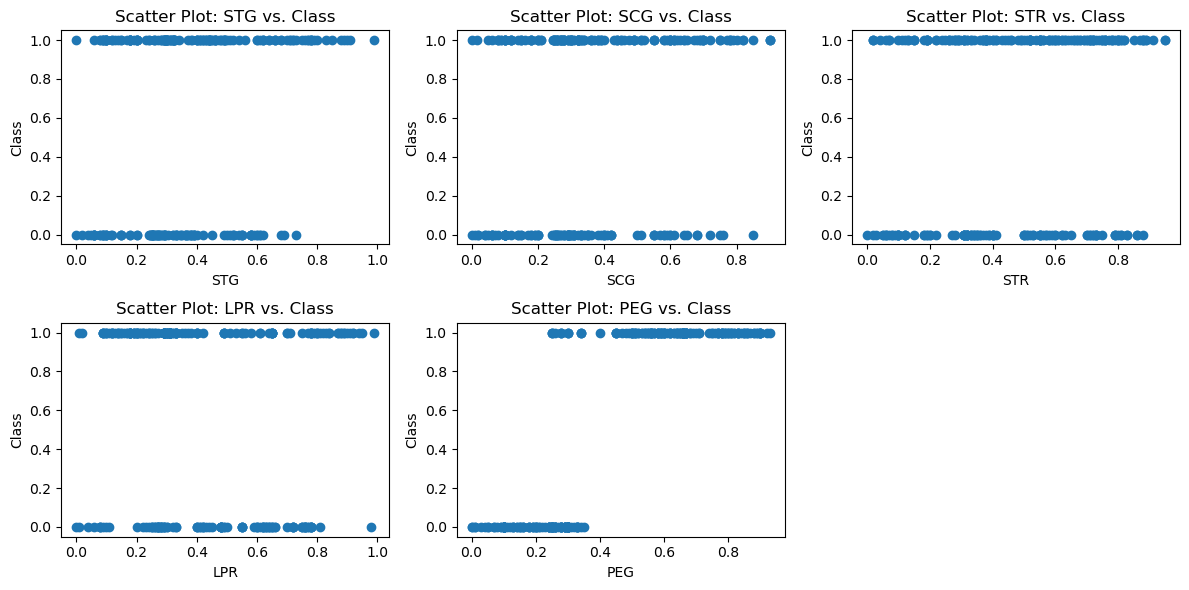

In [33]:
def scatter_plot(feature, target):
    plt.scatter(feature, target)
    plt.xlabel(feature.name)
    plt.ylabel('Class')
    plt.title('Scatter Plot: {} vs. Class'.format(feature.name))

plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns):
    plt.subplot(2, 3, i+1)
    scatter_plot(X[col], y)
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из кривых значения критерия Джини деление выборки на два поддерева стоит производить по признаку PEG, что согласуется с визуальной оценкой диаграмм рассеяния. Кривая для "хороших" признаков, по которым выборка делится почти идеально, выглядит как перевернутое нормальное распределение с е

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

In [9]:
data_mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header = None)
labelencoder = LabelEncoder()
for col in data_mushrooms.columns:
    data_mushrooms[col] = labelencoder.fit_transform(data_mushrooms[col])

In [14]:
X = data_mushrooms.drop(columns=0)  
y = data_mushrooms[0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=13
)

dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Decision tree accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

Decision tree accuracy: 1.00


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [33]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [17]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

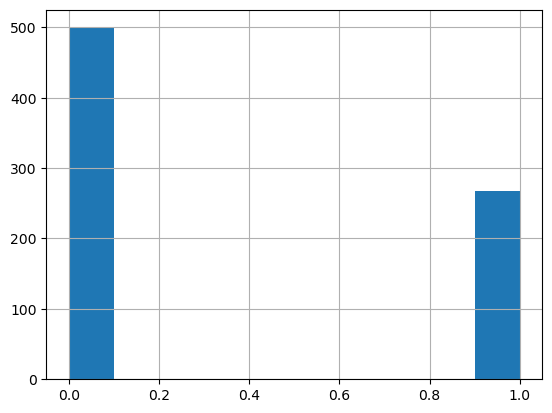

In [18]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [19]:
X = data.drop(columns=['Outcome'])  
y = data['Outcome']

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [27]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

In [12]:
max_depth_values = [3, 5, 7, 9, 10]  
min_samples_leaf_values = [1, 2, 4, 6, 8]

best_max_depth = None
best_min_samples_leaf = None
best_f1_score = -1

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:

        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
        
        
        y_pred = clf.predict(X_val)
        
       
        current_f1_score = f1_score(y_val, y_pred, average='macro')
        
        
        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf
            
print(f'Best max_depth: {best_max_depth}')
print(f'Best min_samples_leaf: {best_min_samples_leaf}')
print(f'Best f1 Score: {best_f1_score}')

Best max_depth: 5
Best min_samples_leaf: 1
Best f1 Score: 0.7654673519893394


In [28]:
best_clf = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
best_clf.fit(X_train_full, y_train_full)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score (y_test, y_pred)

print(f'Accuracy: {round(accuracy,2)}')
print(f'Precision: {round(precision,2)}')
print(f'Recall: {round(recall,2)}')
print(f'AUC-ROC: {round(auc_roc,2)}')

Accuracy: 0.77
Precision: 0.68
Recall: 0.65
AUC-ROC: 0.74


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [31]:
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train_full, y_train_full)

y_pred = bagging_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score (y_test, y_pred)


print(f'Accuracy: {round(accuracy,2)}')
print(f'Precision: {round(precision, 2)}')
print(f'Recall: {round(recall, 2)}')
print(f'AUC-ROC: {round(auc_roc,2)}')

Accuracy: 0.75
Precision: 0.63
Recall: 0.69
AUC-ROC: 0.73


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [34]:
max_depth_values = [10, 20, 30, 40, 50]
min_samples_split_values = [2, 5, 10, 20]


best_score = 0
best_params = {'max_depth': None, 'min_samples_split': None}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        scores = cross_val_score(rf, X_train_full, y_train_full, cv=5, scoring='f1_weighted')
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_params['max_depth'] = max_depth
            best_params['min_samples_split'] = min_samples_split

print(f"Лучшие параметры: {best_params}")
print(f"Лучший F1-score (кросс-валидация): {best_score}")

Лучшие параметры: {'max_depth': 20, 'min_samples_split': 20}
Лучший F1-score (кросс-валидация): 0.7759880363130688


In [35]:
best_rf = RandomForestClassifier(n_estimators=50, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)
best_rf.fit(X_train_full, y_train_full)


y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score (y_test, y_pred)

print(f'Accuracy: {round(accuracy,2)}')
print(f'Precision: {round(precision, 2)}')
print(f'Recall: {round(recall, 2)}')
print(f'AUC-ROC: {round(auc_roc,2)}')

Accuracy: 0.76
Precision: 0.66
Recall: 0.67
AUC-ROC: 0.74


Random Forest и Decison Tree получились примерно одинаковыми практически по всем посчитанными нами метриками. У Random Forest полнота чуть больше, а точность меньше по сравнению с Decision Tree (что и логично, поскольку эти метрики будут обратно пропорциональны). Какой метод для предсказания значений модели выбрать зависит от цели нашей задачи, то есть от того, что нам важнее получить, больший recall или больший precision

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

n_estimators: 10, AUC: 0.801010101010101
n_estimators: 20, AUC: 0.8024793388429753
n_estimators: 50, AUC: 0.7981634527089072
n_estimators: 100, AUC: 0.8120293847566575
n_estimators: 200, AUC: 0.8183654729109275
n_estimators: 300, AUC: 0.8206611570247934
n_estimators: 400, AUC: 0.8242424242424242
n_estimators: 500, AUC: 0.827364554637282


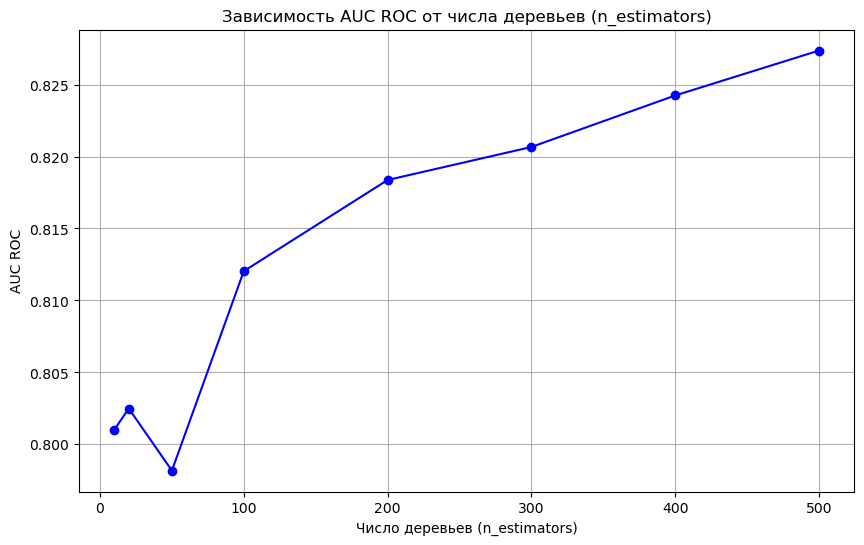

In [36]:
n_estimators_values = [10, 20, 50, 100, 200, 300, 400, 500]

auc_scores = []

for n in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_full, y_train_full)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)
    print(f'n_estimators: {n}, AUC: {auc}')


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, auc_scores, marker='o', linestyle='-', color='b')
plt.title('Зависимость AUC ROC от числа деревьев (n_estimators)')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('AUC ROC')
plt.grid(True)
plt.show()

Чем больше число деревьев, тем выще метрика AUC-ROC, что означает лучшую способность предсказания нашей моделью верного результата, таким образом, с ростом числа деревьев уменьшается смещение, модель становиться более сложной, но проблема будет заключаться в том, что если модель будет достаточно сложной, она переобучиться и не будет иметь хорошую предсказательность на новых данных.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

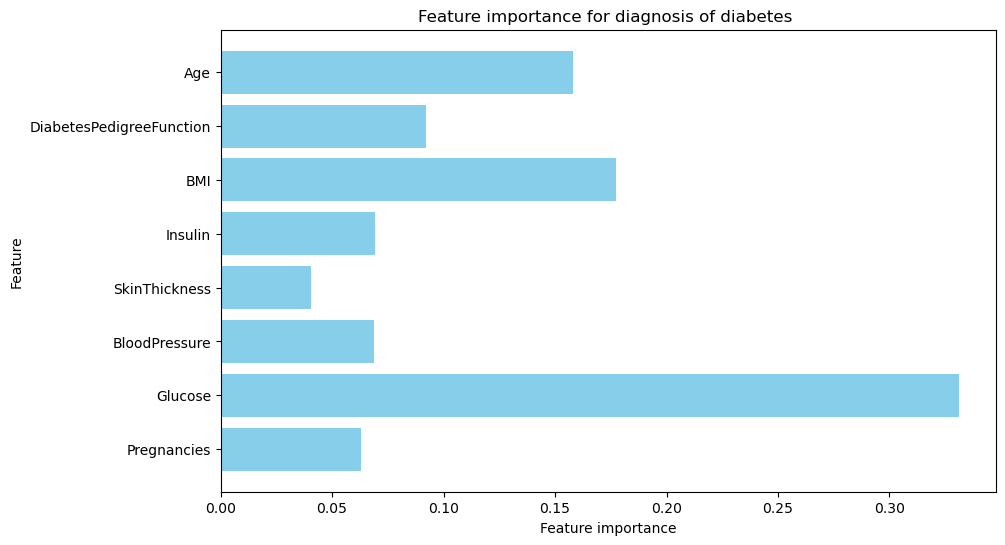

The most important feature: Glucose


In [37]:
feature_importances = best_rf.feature_importances_
feature_names = X.columns.tolist()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Feature importance for diagnosis of diabetes ')
plt.show()


most_important_feature_index = np.argmax(feature_importances)
most_important_feature = feature_names[most_important_feature_index]

print(f'The most important feature: {most_important_feature}')